In [36]:
#
import mne
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy import io
from egtplot import plot_static


import librosa
import librosa.display as libdisp
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture 

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
import matplotlib as mpl
import pickle

data_path = os.path.dirname(os.getcwd())

subject_name = ['stella','juliet','shai','ayoub','lucas','simone','henry', 'julien','marion','elvira']
partner_name = ['juliet','stella','ayoub','shai','simone','lucas','julien', 'henry', 'elvira','marion']

subject_group = [('stella','juliet'),('shai','ayoub'),('lucas','simone'),('henry', 'julien'),('marion','elvira')]
subject_group_no = [1,1,2,2,3,3,4,4,5,5]
subject_gender = ['f','f','m','m','m','m','m','m','f','f']
subject_speak = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
session_name = ['pre','duet1', 'duet2', 'duet3' ,'duet4','duet5','duet6','post']
session_words = [60,50,50,50,50,50,50,60]
eeg_label =     ['F3','C3','P3','Cz','F4','C4','P4','P7']
ema_label = ['jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

ema_fs = 100

idx = [np.arange(1,60),np.arange(61,160),np.arange(161,260),np.arange(261,360),np.arange(361,460)
       ,np.arange(461,560),np.arange(561,660),np.arange(661,720)]

raw_fname = data_path + '/fieldtrip/data/enobio8_ferrara_french2.mat'
mat = io.loadmat(raw_fname)
pos = mat['lay']['pos'][0][0]

In [2]:
n_components = [4,8,16,32,64,128,256,512]

GMM_components = 4
covariance_type='diag'


In [3]:
# get GMM model data


save_path = data_path + '/python/data/data.pkl'
data=pd.read_pickle(save_path)

save_path = data_path + '/python/data/gmm_scores_'+covariance_type+'_'+str(GMM_components)+'.pkl'
gmm_scores=pd.read_pickle(save_path)

df = pd.merge(data,gmm_scores,on='wav')
df.head(3)

,subject,session,words,partner,wav,EEGS,EEGS_time,EEGL,EEGL_time,trial_noS,...,GMM_stella,GMM_juliet,GMM_shai,GMM_ayoub,GMM_lucas,GMM_simone,GMM_henry,GMM_julien,GMM_marion,GMM_elvira
0,stella,pre,péchant,juliet,stella-pre_1_.wav,"[[43577.10795400812, 20184.207429459435, -159....","[[-0.512, -0.51, -0.508, -0.506, -0.504, -0.50...",[],[],1.0,...,66.5047,16.4308,33.9014,56.0794,25.9134,57.9044,23.6688,56.8795,6.04054,63.2851
1,stella,pre,paumé,juliet,stella-pre_2_.wav,"[[-8101.605861944673, -30411.99562233412, -495...","[[-0.512, -0.51, -0.508, -0.506, -0.504, -0.50...",[],[],2.0,...,74.8129,43.7024,54.8765,67.1304,52.0563,66.6677,45.993,65.8454,38.0899,70.8109
2,stella,pre,city,juliet,stella-pre_3_.wav,"[[73245.14487949017, 42778.887419735394, 16209...","[[-0.514, -0.512, -0.51, -0.508, -0.506, -0.50...",[],[],3.0,...,74.3762,39.9785,52.937,69.5032,56.1645,68.9908,50.402,68.9301,48.2366,71.6661


In [4]:
# arrange data
X = [50,100,150,200,250]
A = []
for s in subject_name:
    a = df[(df['session']=='duet1') & (df['subject']==s)][['subject','session','wordNo',
                                                                           'GMM_stella', 'GMM_juliet', 
                                                                           'GMM_shai', 'GMM_ayoub','GMM_lucas', 
                                                                           'GMM_simone', 'GMM_henry', 'GMM_julien', 
                                                                           'GMM_marion','GMM_elvira']]
    A.append(a)
    for ss in range(2,len(session_name)-1):
        a = df[(df['session']==session_name[ss]) & (df['subject']==s)][['subject','session','wordNo',
                                                                           'GMM_stella', 'GMM_juliet', 
                                                                           'GMM_shai', 'GMM_ayoub','GMM_lucas', 
                                                                           'GMM_simone', 'GMM_henry', 'GMM_julien', 
                                                                           'GMM_marion','GMM_elvira']]
        a['wordNo'] = a['wordNo'].get_values() + X[ss-2]
        A.append(a)
    
A = pd.concat((A),axis=0)
A['wordIDX'] = A['session'] +'_'+ A['wordNo'].map(str)
A.head()


,subject,session,wordNo,GMM_stella,GMM_juliet,GMM_shai,GMM_ayoub,GMM_lucas,GMM_simone,GMM_henry,GMM_julien,GMM_marion,GMM_elvira,wordIDX
60,stella,duet1,1,68.6264,33.7702,46.9597,64.5629,39.4651,66.0724,42.3497,60.951,30.4654,70.8346,duet1_1
61,stella,duet1,2,69.4735,30.3021,50.7078,63.7836,43.7411,62.4955,40.079,62.3929,25.2473,63.3807,duet1_2
62,stella,duet1,3,68.2955,11.4053,38.0958,61.3624,30.2491,59.2316,23.1545,65.6953,0.341649,66.6035,duet1_3
63,stella,duet1,4,72.2946,49.9367,61.5982,68.4027,55.7333,66.9259,55.1298,69.0407,49.1981,67.2792,duet1_4
64,stella,duet1,5,80.2514,44.5289,59.7771,73.812,54.8778,71.6451,48.1714,70.4848,42.7992,76.7575,duet1_5


# GMM score investigation

[[12.51237574 29.27828482 52.80918055]
 [ 7.50016134 11.11208182 14.40504699]
 [ 4.70190487  9.58838788 13.7227287 ]
 [ 7.22947466 20.12140179 34.7932319 ]
 [ 5.47933216  8.70534395 11.93149012]
 [ 2.98651883 11.76398971 22.32770813]
 [ 4.27822749  8.98235612 13.81410319]
 [13.94846073 27.24190356 39.85930802]
 [ 9.05896547 13.40665485 18.06555042]
 [16.65088888 30.35115025 58.39384715]]


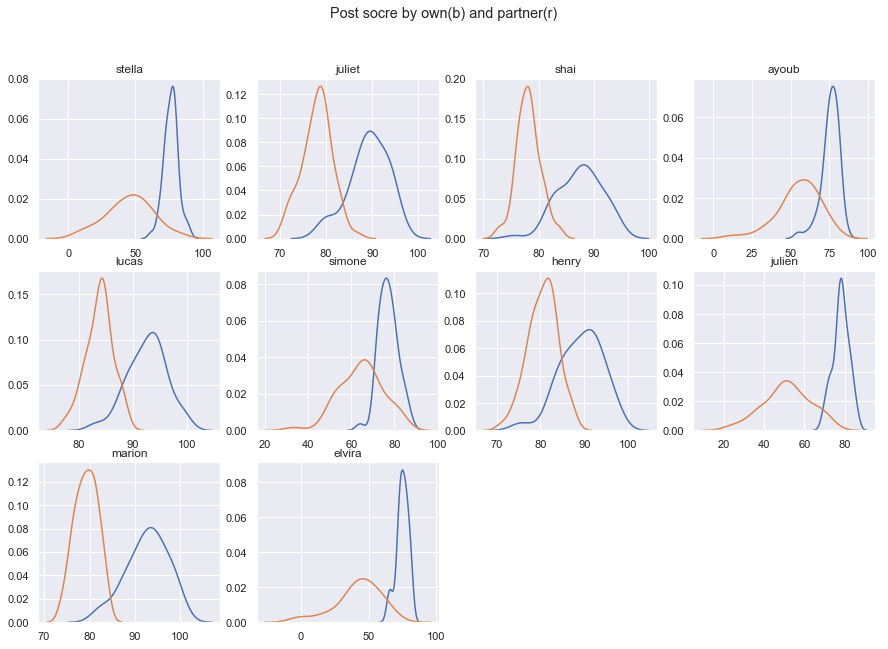

In [5]:
# GMM baseline theshold from post distribution
baseline_threshold=[]

f, AX = plt.subplots(figsize=(15,10))
sns.set(font_scale=1)
for i in range(0,len(subject_name)):
    s=subject_name[i]
    p=partner_name[i]
    
    a=df[(df['session']=='post')&(df['subject']==s)]['GMM_'+s].get_values()
    #print(np.percentile(a,95),np.percentile(a,5))

    b=df[(df['session']=='post')&(df['subject']==s)]['GMM_'+p].get_values()
    #print(np.percentile(b,95),np.percentile(b,5))
    
    baseline_threshold.append((np.percentile(a-b,5),np.percentile(a-b,50),np.percentile(a-b,95)))
    
    plt.subplot(3,4,i+1)
    _=sns.kdeplot(a)
    _=sns.kdeplot(b)
    plt.title(s)
    
#plt.legend(['Pre','Post'])
_=plt.suptitle('Post socre by own(b) and partner(r)')    

baseline_threshold=np.stack(baseline_threshold)
print(baseline_threshold)

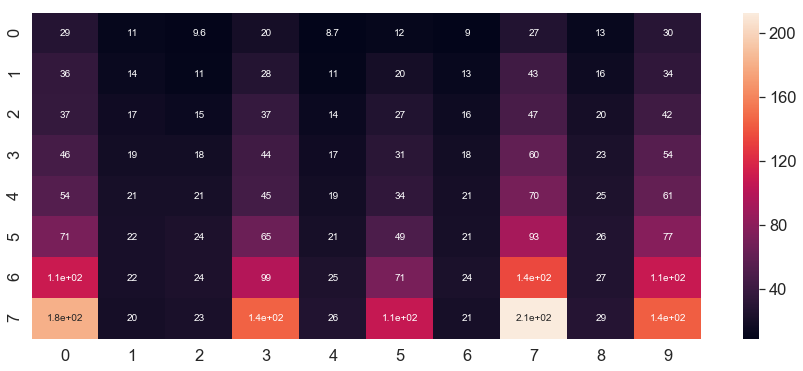

In [33]:
# GMM baseline theshold from post distribution
save_path = data_path + '/python/data/data.pkl'
data=pd.read_pickle(save_path)
GMM =[]
for n in range(0,len(n_components)):

    save_path = data_path + '/python/data/gmm_scores_'+covariance_type+'_'+str(n_components[n])+'.pkl'
    gmm_scores=pd.read_pickle(save_path)

    df = pd.merge(data,gmm_scores,on='wav')
    
       
    baseline_threshold=[]

    for i in range(0,len(subject_name)):
        s=subject_name[i]
        p=partner_name[i]

        a=df[(df['session']=='post')&(df['subject']==s)]['GMM_'+s].get_values()
        #print(np.percentile(a,95),np.percentile(a,5))

        b=df[(df['session']=='post')&(df['subject']==s)]['GMM_'+p].get_values()
        #print(np.percentile(b,95),np.percentile(b,5))

        baseline_threshold.append((np.percentile(a-b,5),np.percentile(a-b,50),np.percentile(a-b,95)))
    
    
    baseline_threshold=np.stack(baseline_threshold)
    GMM.append(baseline_threshold)
GMM = np.stack(GMM)

f, AX = plt.subplots(figsize=(15,6))

sns.heatmap(GMM[:,:,1],annot=True)

In [36]:
np.mean(GMM[:,:,1],axis=1)

array([17.05515548, 22.63117049, 27.28592729, 33.08746058, 37.12129145,
       47.06425138, 64.4822828 , 90.84686992])

Text(0.5, 1.0, 'juliet_stella')

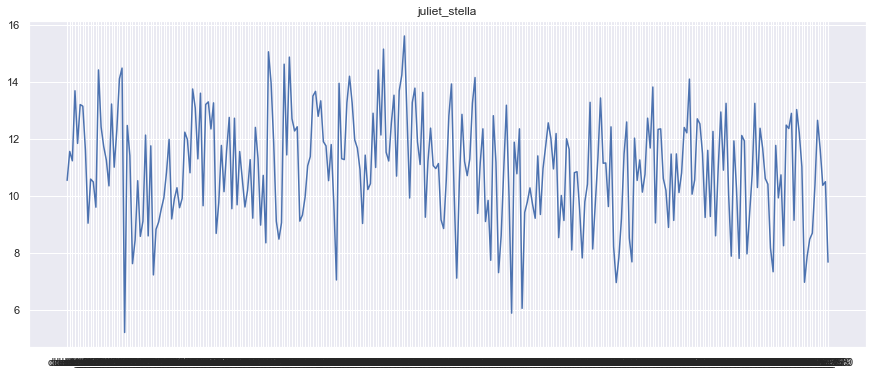

In [66]:
# check duet score diff between own model - partner model
i=1
s=subject_name[i]
p=partner_name[i]
a=A[(A['session'].isin(session_name[1:-1]))&(A['subject']==s)]
aa = a['GMM_'+s].get_values()
bb= a['GMM_'+p].get_values()


f, AX = plt.subplots(figsize=(15,6))

#_=plt.plot(a['wordIDX'],aa)
#_=plt.plot(a['wordIDX'],bb)
_=plt.plot(a['wordIDX'],aa-bb)
plt.title(s+'_'+p)

In [6]:
# convergence computation

# old convergence wtih frequncy of LLr score
# https://paper.dropbox.com/doc/Speech-Convergence-calculation-rn3VdhQVUH6TCYXPdEHrz

def get_strategies(A):

    strategies = []
    for i in range(0,A.shape[0]):
        a = A.iloc[i][['GMM_stella', 'GMM_juliet', 'GMM_shai', 'GMM_ayoub','GMM_lucas', 
                       'GMM_simone', 'GMM_henry', 'GMM_julien', 
                       'GMM_marion','GMM_elvira']].get_values()
        b=np.where(a==a.max())

        NoChange = 0
        Convergence = 0
        Divergence = 0
        if(A.iloc[i]['subject']==subject_name[b[0][0]]):
            NoChange = 1
        elif(A.iloc[i]['subject']==partner_name[b[0][0]]):
            Convergence = 1
        else:
            Divergence = 1
        a = np.where(np.asarray(subject_name)==A.iloc[i]['subject'])[0][0]
        a = pd.DataFrame({'group':subject_group_no[a]-1,'wordNo':A.iloc[i]['wordNo'],
                          'subject':A.iloc[i]['subject'],
                          'session':session_name.index(A.iloc[i]['session']),
                          'NoChange':[NoChange],'Convergence':Convergence,
                          'Divergence':Divergence})    
        strategies.append(a)     

    strategies = pd.concat((strategies),axis=0)
    return strategies

# own and partner model score on post data. then difference of the scores. 
# get the 5 and 95 percentile of the difference distribution.
# now compute the socre in duet for both models. if the duet score difference is bigger than 95
# percentile then divergence, if smaller than 5 percentile then convergence
# otherwise nochange

def get_convergence(A,baseline_threshold):

    strategies = []
    for i in range(0,A.shape[0]):        
        s = A.iloc[i]['subject']
        s_idx = subject_name.index(s)
        p = partner_name[s_idx]
        
        a = A.iloc[i]['GMM_'+s] - A.iloc[i]['GMM_'+p]
        
        
        NoChange = 0
        Convergence = 0
        Divergence = 0
        score_diff=0
        if(baseline_threshold[s_idx,0]<a<baseline_threshold[s_idx,2]):
            NoChange = 1
        elif(baseline_threshold[s_idx,0]>=a):
            Convergence = 1
        elif(baseline_threshold[s_idx,2]<=a):
            Divergence = 1
            
        aa = np.where(np.asarray(subject_name)==A.iloc[i]['subject'])[0][0]
        
        
        a = pd.DataFrame({'group':subject_group_no[aa]-1,'wordNo':A.iloc[i]['wordNo'],
                          'subject':A.iloc[i]['subject'],
                          'session':session_name.index(A.iloc[i]['session']),
                          'NoChange':[NoChange],'Convergence':Convergence,
                          'Divergence':Divergence,
                          'mean_score_ratio':a / baseline_threshold[s_idx,1]})    
        strategies.append(a)     

    strategies = pd.concat((strategies),axis=0)
    return strategies



strategies = get_convergence(A,baseline_threshold)
strategies = strategies.melt(['group','wordNo','subject','session','mean_score_ratio'], 
                             var_name='type', value_name='data')

strategies['GMM_comp'] = pd.Series(np.repeat(GMM_components,len(strategies)), 
                                   index=strategies.index)
strategies['GMM_cov_type'] = pd.Series(np.repeat(covariance_type,len(strategies)), 
                                       index=strategies.index)

save_path = data_path + '/python/data/conv_'+covariance_type+'_'+str(GMM_components)+'.pkl'
strategies.to_pickle(save_path)

strategies.head()

,group,wordNo,subject,session,mean_score_ratio,type,data,GMM_comp,GMM_cov_type
0,0,1,stella,1,1.190514,NoChange,1,4,diag
1,0,2,stella,1,1.337898,NoChange,1,4,diag
2,0,3,stella,1,1.943083,NoChange,0,4,diag
3,0,4,stella,1,0.763633,NoChange,1,4,diag
4,0,5,stella,1,1.220104,NoChange,1,4,diag


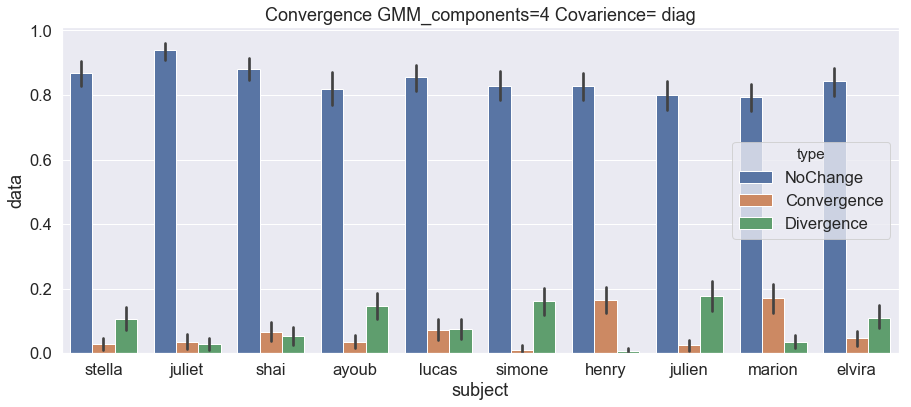

In [7]:
#
sns.set(font_scale=1.5)


f, AX = plt.subplots(figsize=(15,6))

ax = sns.barplot(x="subject", y="data", hue='type',data=strategies)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

#change_width(ax, .65)
_=plt.title('Convergence GMM_components='+str(GMM_components)+' Covarience= '+covariance_type)
#_=plt.xlim([-1,10])

Text(0, 0.5, 'Convergence_freq')

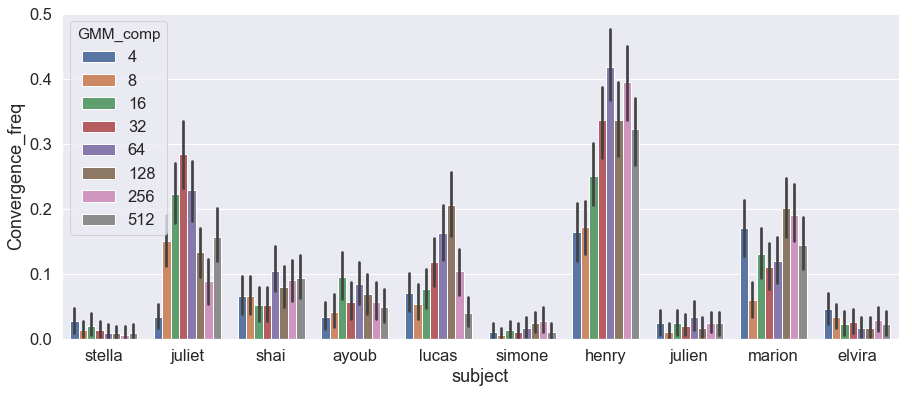

In [76]:
#batch 
A=[]
for i in range(0,len(n_components)):    
    save_path = data_path + '/python/data/conv_'+covariance_type+'_'+str(n_components[i])+'.pkl'
    convergence=pd.read_pickle(save_path)
    
    A.append(convergence)
        
A=pd.concat((A),axis=0)

#
sns.set(font_scale=1.5)
a = A[A['type']=='Convergence']
f, AX = plt.subplots(figsize=(15,6))

ax = sns.barplot(x="subject", y="data", hue='GMM_comp',data=a)
plt.ylabel('Convergence_freq')

# old

In [28]:
def get_convergence(A,baseline_threshold):

    strategies = []
    for i in range(0,A.shape[0]):        
        s = A.iloc[i]['subject']
        s_idx = subject_name.index(s)
        p = partner_name[s_idx]
        
        a = A.iloc[i]['GMM_'+s] - A.iloc[i]['GMM_'+p]
        
        
        NoChange = 0
        Convergence = 0
        Divergence = 0
        score_diff=0
        if(baseline_threshold[s_idx,0]<a<baseline_threshold[s_idx,2]):
            NoChange = 1
        elif(baseline_threshold[s_idx,0]>=a):
            Convergence = 1
        elif(baseline_threshold[s_idx,2]<=a):
            Divergence = 1
            
        aa = np.where(np.asarray(subject_name)==A.iloc[i]['subject'])[0][0]
        X = np.zeros((1,3))[0]
        X[0] = NoChange
        X[1] = Convergence
        X[2] = Divergence

        
        a = pd.DataFrame({'group':subject_group_no[aa]-1,'wordNo':A.iloc[i]['wordNo'],
                          'subject':A.iloc[i]['subject'],
                          'session':session_name.index(A.iloc[i]['session']),
                          'NoChange':[NoChange],'Convergence':Convergence,
                          'Divergence':Divergence,
                          'mean_score_ratio':a / baseline_threshold[s_idx,1],
                         'data':[X]})    
        strategies.append(a)     

    strategies = pd.concat((strategies),axis=0)
    return strategies



strategies = get_convergence(A,baseline_threshold)
strategies = strategies.sort_values([ 'group','wordNo'], ascending=True)

strategies.head()

,group,wordNo,subject,session,NoChange,Convergence,Divergence,mean_score_ratio,data
0,0,1,stella,1,1,0,0,1.190514,"[1.0, 0.0, 0.0]"
0,0,1,juliet,1,1,0,0,0.949425,"[1.0, 0.0, 0.0]"
0,0,2,stella,1,1,0,0,1.337898,"[1.0, 0.0, 0.0]"
0,0,2,juliet,1,1,0,0,1.040852,"[1.0, 0.0, 0.0]"
0,0,3,stella,1,0,0,1,1.943083,"[0.0, 0.0, 1.0]"


In [72]:
# select group
g=4
# averaging over word points 
w=50
# get replication dynamics data
k=4

297
5


1it [00:00,  6.41it/s]


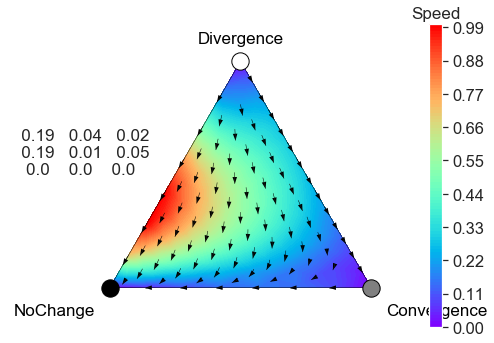

In [76]:
#


def select_group(strategies_sort,g):
    a = strategies_sort[strategies_sort['group']==g]
    unique, counts = np.unique(a['wordNo'].get_values(), return_counts=True)
    unique = np.delete(unique,[np.where(counts==1)])   # remove for missing word

    a = strategies_sort[(strategies_sort['group']==g) & (strategies_sort['wordNo'].isin(unique))]['data']
    a = np.stack(a)
    #a.shape  # should be even
    X = np.array_split(a,a.shape[0]/2)
    return X

X = select_group(strategies,g)
print(len(X))


def get_group(X,g):
    # grouping 
    xx = np.array_split(np.arange(0,len(X)),np.floor(len(X)/g))

    X_avg = []
    for i in range(0,len(xx)):
        x = np.dstack(X[xx[i][0]:xx[i][-1]])
        x = np.mean(x,axis=2)
        X_avg.append(x)
    return X_avg

X_avg = get_group(X,w)
print(len(X_avg))




def plot_RD(x):
    # replication dynamics
    z = np.vstack((x,np.zeros((1,3))[0]))
    b=z.flatten()/g

    z=[]
    for i in range(0,9):
        z.append([b[i]])
        
    return z


z=plot_RD(X_avg[k])

simplex = plot_static(z, vert_labels=['NoChange', 'Convergence', 'Divergence'],background=True)

In [87]:
X_avg[k]

array([[0.77586207, 0.15517241, 0.06896552],
       [0.74137931, 0.05172414, 0.20689655]])

In [77]:
z

[[0.1939655172413793],
 [0.03879310344827586],
 [0.017241379310344827],
 [0.1853448275862069],
 [0.01293103448275862],
 [0.05172413793103448],
 [0.0],
 [0.0],
 [0.0]]

In [86]:
def get_payoff(alpha, beta, gamma):
    return [[0, alpha, 0], 
            [1 + alpha - beta, 1 - 2 * beta, 1 - beta], 
            [1 - gamma, 1 - gamma, 1 - gamma]]
z = [[9], [1], [1]]
simplex = plot_static(z, vert_labels=['NoChange', 'Convergence', 'Divergence'],background=True)


0it [00:00, ?it/s]


ValueError: cannot reshape array of size 3 into shape (3,3)

<Figure size 432x432 with 0 Axes>

In [1]:
#sns.tsplot(data=A,time='wordNo',value='GMM_juliet',unit='subject')
#sns.tsplot(data=A,time='wordNo',value='GMM_stella',unit='subject')